In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy import stats
import folium
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
from datetime import datetime

### Set plot style

In [54]:
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### Load data

In [55]:
def load_data(data_path='./carla_data'):
    """
    Load all data files from the specified directory
    """
    # Find the latest files if multiple exist
    ego_files = [f for f in os.listdir(data_path) if f.startswith('ego_data')]
    lane_files = [f for f in os.listdir(data_path) if f.startswith('lane_data')]
    
    # If no files found, return empty dataframes
    if not ego_files or not lane_files:
        print("No data files found in the specified directory!")
        return pd.DataFrame(), pd.DataFrame()
    
    # Sort by timestamp in filename to get latest
    ego_files.sort(reverse=True)
    lane_files.sort(reverse=True)
    
    print(f"Loading latest data files: \n{ego_files[0]}\n{lane_files[0]}")
    
    # Load the data
    ego_data = pd.read_csv(os.path.join(data_path, ego_files[0]))
    lane_data = pd.read_csv(os.path.join(data_path, lane_files[0]))
    
    return ego_data, lane_data

# Load the data
data_path = './carla_data'  # Update this path to where your data is stored
ego_data, lane_data = load_data(data_path)

Loading latest data files: 
ego_data_20250505_190810.csv
lane_data_20250505_190810.csv


### Basic information about the datasets

In [56]:
print("Ego Vehicle Data Overview:")
print(f"Shape: {ego_data.shape}")
ego_data.head()

Ego Vehicle Data Overview:
Shape: (8136, 15)


timestamp          x          y         z  steering  throttle  brake        yaw    heading    velocity_x    velocity_y  velocity_z   accel_x   accel_y    accel_z
0  648.568412 -48.839951 -17.213200  0.394200 -0.004439      0.85    0.0  90.432327  90.432326  0.000000e+00  0.000000e+00   -1.960000  0.000000  0.000000  -9.800002
1  648.668412 -48.839951 -17.213200  0.144300 -0.012317      0.85    0.0  90.432327  90.432326  0.000000e+00  0.000000e+00   -2.940000  0.000000  0.000000  -9.800000
2  648.768412 -48.839951 -17.213198 -0.051763 -0.009706      0.85    0.0  90.432327  90.432326  1.375433e-06 -1.624710e-07   -0.739277  0.000014 -0.000002  22.007235
3  648.868412 -48.839951 -17.213198 -0.064677 -0.009720      0.85    0.0  90.432327  90.432326 -3.444219e-07  2.007732e-09    0.150424 -0.000017  0.000002   8.897012
4  648.968412 -48.839973 -17.206451 -0.042352 -0.009716      0.85    0.0  90.430183  90.430181 -3.218568e-04  4.001724e-01    0.233783 -0.003215  4.001723   0.833591

In [57]:
print("\nData Types:")
print(ego_data.dtypes)
print("\nBasic Statistics:")
ego_data.describe()


Data Types:
timestamp     float64
x             float64
y             float64
z             float64
steering      float64
throttle      float64
brake         float64
yaw           float64
heading       float64
velocity_x    float64
velocity_y    float64
velocity_z    float64
accel_x       float64
accel_y       float64
accel_z       float64
dtype: object

Basic Statistics:


timestamp            x            y            z     steering     throttle        brake          yaw      heading   velocity_x   velocity_y    velocity_z       accel_x       accel_y      accel_z
count  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8136.000000  8.136000e+03  8.136000e+03  8.136000e+03  8136.000000
mean   1055.318418   -24.705710    32.436912     0.001861     0.000021     0.252561     0.403504   -39.960915   -39.960914     0.000424     0.152166 -5.842715e-04  4.635252e-11 -9.514373e-11     0.001205
std     234.880526    74.663270    59.494509     0.004768     0.057423     0.271751     0.481773   100.964948   100.964948     3.994584     4.063445  4.026289e-02  1.950471e+00  2.145230e+00     0.307099
min     648.568412  -114.540146   -68.670364    -0.064677    -0.373194     0.000000     0.000000  -179.998917  -179.998912    -8.626304    -8.621225 -2.940000e+00 -2.689047e+01 -2.677951e+01    -9.800002
25%     851.943415   -87.771545     0.545360     0.001699    -0.001459     0.000000     0.000000   -92.409798   -92.409796    -0.089761    -0.029237 -7.438659e-07 -5.762102e-03 -1.680368e-02    -0.000009
50%    1055.318418   -48.637203    30.120870     0.001841     0.000000     0.241723     0.000000   -87.081055   -87.081053     0.000000     0.000000  0.000000e+00  0.000000e+00  0.000000e+00     0.000000
75%    1258.693421    30.141791    58.543395     0.001871     0.000176     0.388884     1.000000    39.674541    39.674542     0.044350     0.044875  1.032352e-06  1.358860e-02  1.058307e-02     0.000007
max    1462.068424   109.962631   141.184326     0.394200     0.402749     0.850000     1.000000   179.999603   179.999595     8.627901     8.629630  2.337833e-01  2.682750e+01  2.676275e+01    22.007235

In [58]:
print("Lane Data Overview:")
print(f"Shape: {lane_data.shape}")
lane_data.head()

Lane Data Overview:
Shape: (137632, 9)


timestamp lane_id  lane_width  waypoint_x  waypoint_y  waypoint_z  is_junction lane_type  is_drivable
0  648.568412    16_1         3.5  -48.839951  -17.213200         0.0        False   Driving         True
1  648.568412    16_1         3.5  -48.850853  -15.205825         0.0        False   Driving         True
2  648.568412    16_1         3.5  -48.853241  -13.198404         0.0        False   Driving         True
3  648.568412    16_1         3.5  -48.847115  -11.190992         0.0        False   Driving         True
4  648.568412    16_1         3.5  -48.835972   -9.190274         0.0        False   Driving         True

In [59]:
print("\nData Types:")
print(lane_data.dtypes)
print("\nBasic Statistics:")
lane_data.describe()


Data Types:
timestamp      float64
lane_id         object
lane_width     float64
waypoint_x     float64
waypoint_y     float64
waypoint_z     float64
is_junction       bool
lane_type       object
is_drivable       bool
dtype: object

Basic Statistics:


timestamp  lane_width     waypoint_x     waypoint_y  waypoint_z
count  137632.000000    137632.0  137632.000000  137632.000000    137632.0
mean     1055.620304         3.5     -24.780814      31.924066         0.0
std       234.938970         0.0      74.641046      59.537312         0.0
min       648.568412         3.5    -114.595230     -68.730713         0.0
25%       851.968415         3.5     -88.113729       5.214155         0.0
50%      1056.218418         3.5     -48.605328      29.767431         0.0
75%      1259.068421         3.5      30.135824      61.681034         0.0
max      1462.068424         3.5     109.984283     141.214035         0.0

In [60]:
print("Missing values in ego_data:")
print(ego_data.isnull().sum())
print("\nMissing values in lane_data:")
print(lane_data.isnull().sum())

Missing values in ego_data:
timestamp     0
x             0
y             0
z             0
steering      0
throttle      0
brake         0
yaw           0
heading       0
velocity_x    0
velocity_y    0
velocity_z    0
accel_x       0
accel_y       0
accel_z       0
dtype: int64

Missing values in lane_data:
timestamp      0
lane_id        0
lane_width     0
waypoint_x     0
waypoint_y     0
waypoint_z     0
is_junction    0
lane_type      0
is_drivable    0
dtype: int64


In [61]:
def preprocess_ego_data(ego_data):
    """Preprocess ego vehicle data"""
    # Create a copy to avoid modifying the original
    df = ego_data.copy()
    
    # Convert string columns to appropriate types if needed
    # Already numeric in this case
    
    # Add derived features
    df['speed'] = np.sqrt(df['velocity_x']**2 + df['velocity_y']**2 + df['velocity_z']**2)
    df['accel_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)
    
    # Calculate jerk (derivative of acceleration)
    df['jerk_x'] = df['accel_x'].diff() / df['timestamp'].diff()
    df['jerk_y'] = df['accel_y'].diff() / df['timestamp'].diff()
    df['jerk_z'] = df['accel_z'].diff() / df['timestamp'].diff()
    df['jerk_magnitude'] = np.sqrt(df['jerk_x']**2 + df['jerk_y']**2 + df['jerk_z']**2)
    
    # Clean up NaN values from diff operation
    df = df.fillna(method='bfill')
    
    # Calculate distance traveled
    df['dx'] = df['x'].diff()
    df['dy'] = df['y'].diff()
    df['dz'] = df['z'].diff()
    df['distance'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)
    df['cumulative_distance'] = df['distance'].cumsum()
    
    # Apply smoothing to some columns to reduce noise
    window_length = 5  # Must be odd number
    polyorder = 2  # Polynomial order
    
    if len(df) >= window_length:
        for col in ['speed', 'accel_magnitude', 'jerk_magnitude']:
            df[f'{col}_smooth'] = savgol_filter(df[col], window_length, polyorder)
    
    return df

def preprocess_lane_data(lane_data):
    """Preprocess lane data"""
    df = lane_data.copy()
    
    # Convert is_drivable to boolean
    if 'is_drivable' in df.columns and df['is_drivable'].dtype != bool:
        df['is_drivable'] = df['is_drivable'].astype(bool)
    
    # Convert is_junction to boolean if it's not already
    if 'is_junction' in df.columns and df['is_junction'].dtype != bool:
        df['is_junction'] = df['is_junction'].astype(bool)
    
    return df

In [62]:
ego_df = preprocess_ego_data(ego_data)
lane_df = preprocess_lane_data(lane_data)

In [63]:
print("Preprocessed Ego Data:")
ego_df.head()

Preprocessed Ego Data:


timestamp          x          y         z  steering  throttle  brake        yaw    heading    velocity_x    velocity_y  velocity_z   accel_x   accel_y    accel_z     speed  accel_magnitude    jerk_x     jerk_y      jerk_z  jerk_magnitude        dx        dy        dz  distance  cumulative_distance  speed_smooth  accel_magnitude_smooth  jerk_magnitude_smooth
0  648.568412 -48.839951 -17.213200  0.394200 -0.004439      0.85    0.0  90.432327  90.432326  0.000000e+00  0.000000e+00   -1.960000  0.000000  0.000000  -9.800002  1.960000         9.800002  0.000000   0.000000    0.000019        0.000019       NaN       NaN       NaN       NaN                  NaN      2.446869                8.393034             -38.276376
1  648.668412 -48.839951 -17.213200  0.144300 -0.012317      0.85    0.0  90.432327  90.432326  0.000000e+00  0.000000e+00   -2.940000  0.000000  0.000000  -9.800000  2.940000         9.800000  0.000000   0.000000    0.000019        0.000019  0.000000  0.000000 -0.249900  0.249900             0.249900      1.809045               14.646594             118.668328
2  648.768412 -48.839951 -17.213198 -0.051763 -0.009706      0.85    0.0  90.432327  90.432326  1.375433e-06 -1.624710e-07   -0.739277  0.000014 -0.000002  22.007235  0.739277        22.007235  0.000138  -0.000016  318.072343      318.072343  0.000000  0.000002 -0.196063  0.196063             0.445963      1.210927               15.909264             191.725785
3  648.868412 -48.839951 -17.213198 -0.064677 -0.009720      0.85    0.0  90.432327  90.432326 -3.444219e-07  2.007732e-09    0.150424 -0.000017  0.000002   8.897012  0.150424         8.897012 -0.000310   0.000033 -131.102226      131.102226  0.000000  0.000000 -0.012914  0.012914             0.458877      0.071874               11.160015             194.261762
4  648.968412 -48.839973 -17.206451 -0.042352 -0.009716      0.85    0.0  90.430183  90.430181 -3.218568e-04  4.001724e-01    0.233783 -0.003215  4.001723   0.833591  0.463457         4.087624 -0.031979  40.017216  -80.634211       90.018079 -0.000023  0.006746  0.022326  0.023323             0.482200      0.626191                7.497244              93.300341

In [64]:
print("\nPreprocessed Lane Data:")
lane_df.head()


Preprocessed Lane Data:


timestamp lane_id  lane_width  waypoint_x  waypoint_y  waypoint_z  is_junction lane_type  is_drivable
0  648.568412    16_1         3.5  -48.839951  -17.213200         0.0        False   Driving         True
1  648.568412    16_1         3.5  -48.850853  -15.205825         0.0        False   Driving         True
2  648.568412    16_1         3.5  -48.853241  -13.198404         0.0        False   Driving         True
3  648.568412    16_1         3.5  -48.847115  -11.190992         0.0        False   Driving         True
4  648.568412    16_1         3.5  -48.835972   -9.190274         0.0        False   Driving         True

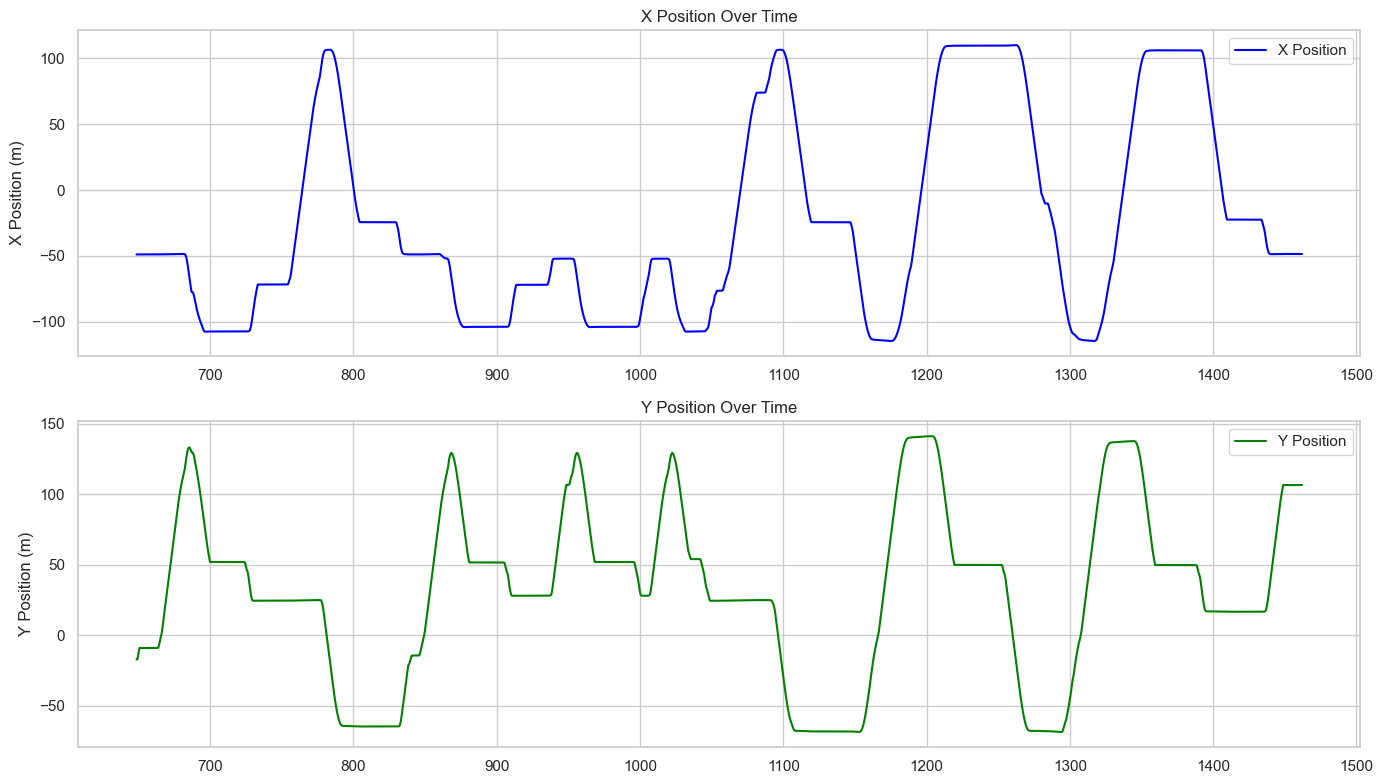

In [65]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(ego_df['timestamp'], ego_df['x'], color='blue', label='X Position')
plt.title('X Position Over Time')
plt.ylabel('X Position (m)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ego_df['timestamp'], ego_df['y'], color='green', label='Y Position')
plt.title('Y Position Over Time')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


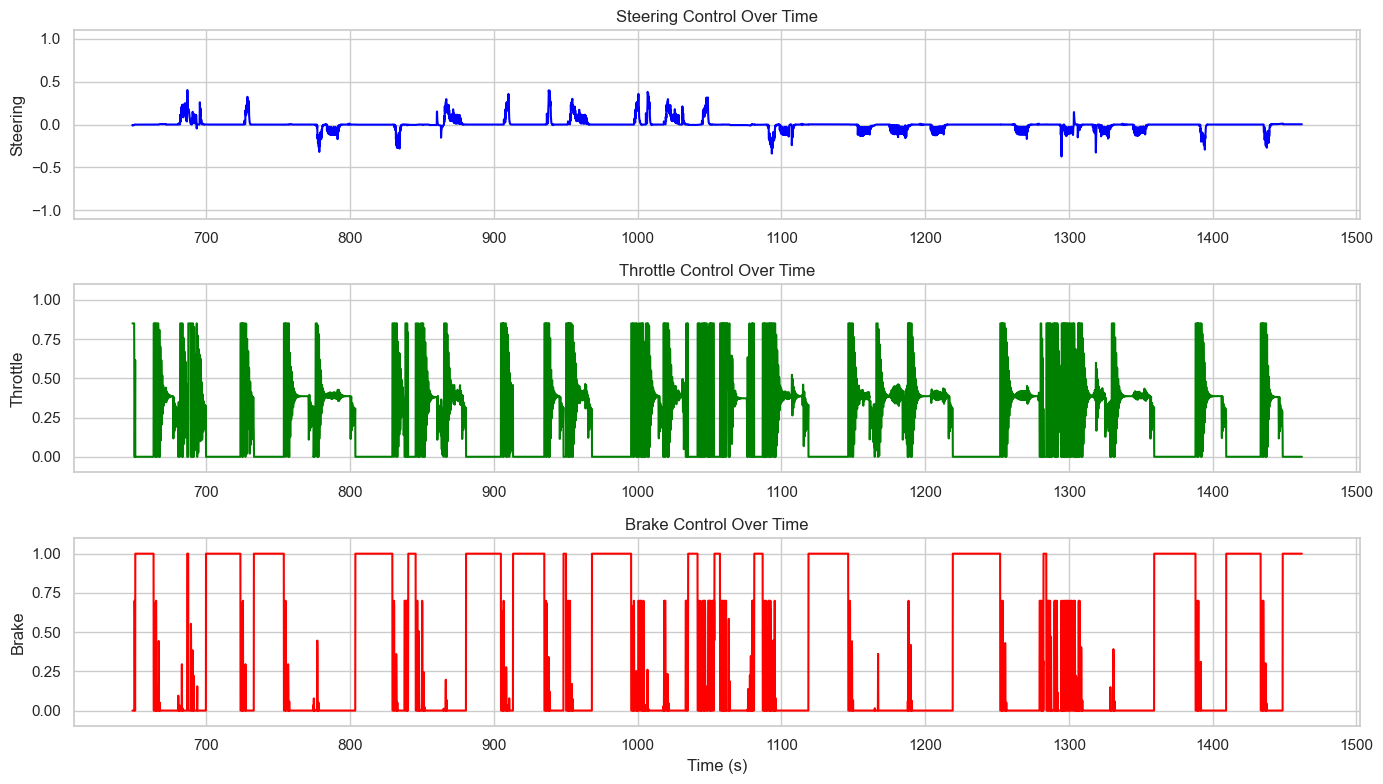

In [66]:
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(ego_df['timestamp'], ego_df['steering'], color='blue')
plt.title('Steering Control Over Time')
plt.ylabel('Steering')
plt.ylim(-1.1, 1.1)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(ego_df['timestamp'], ego_df['throttle'], color='green')
plt.title('Throttle Control Over Time')
plt.ylabel('Throttle')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(ego_df['timestamp'], ego_df['brake'], color='red')
plt.title('Brake Control Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Brake')
plt.ylim(-0.1, 1.1)
plt.grid(True)

plt.tight_layout()
plt.show()

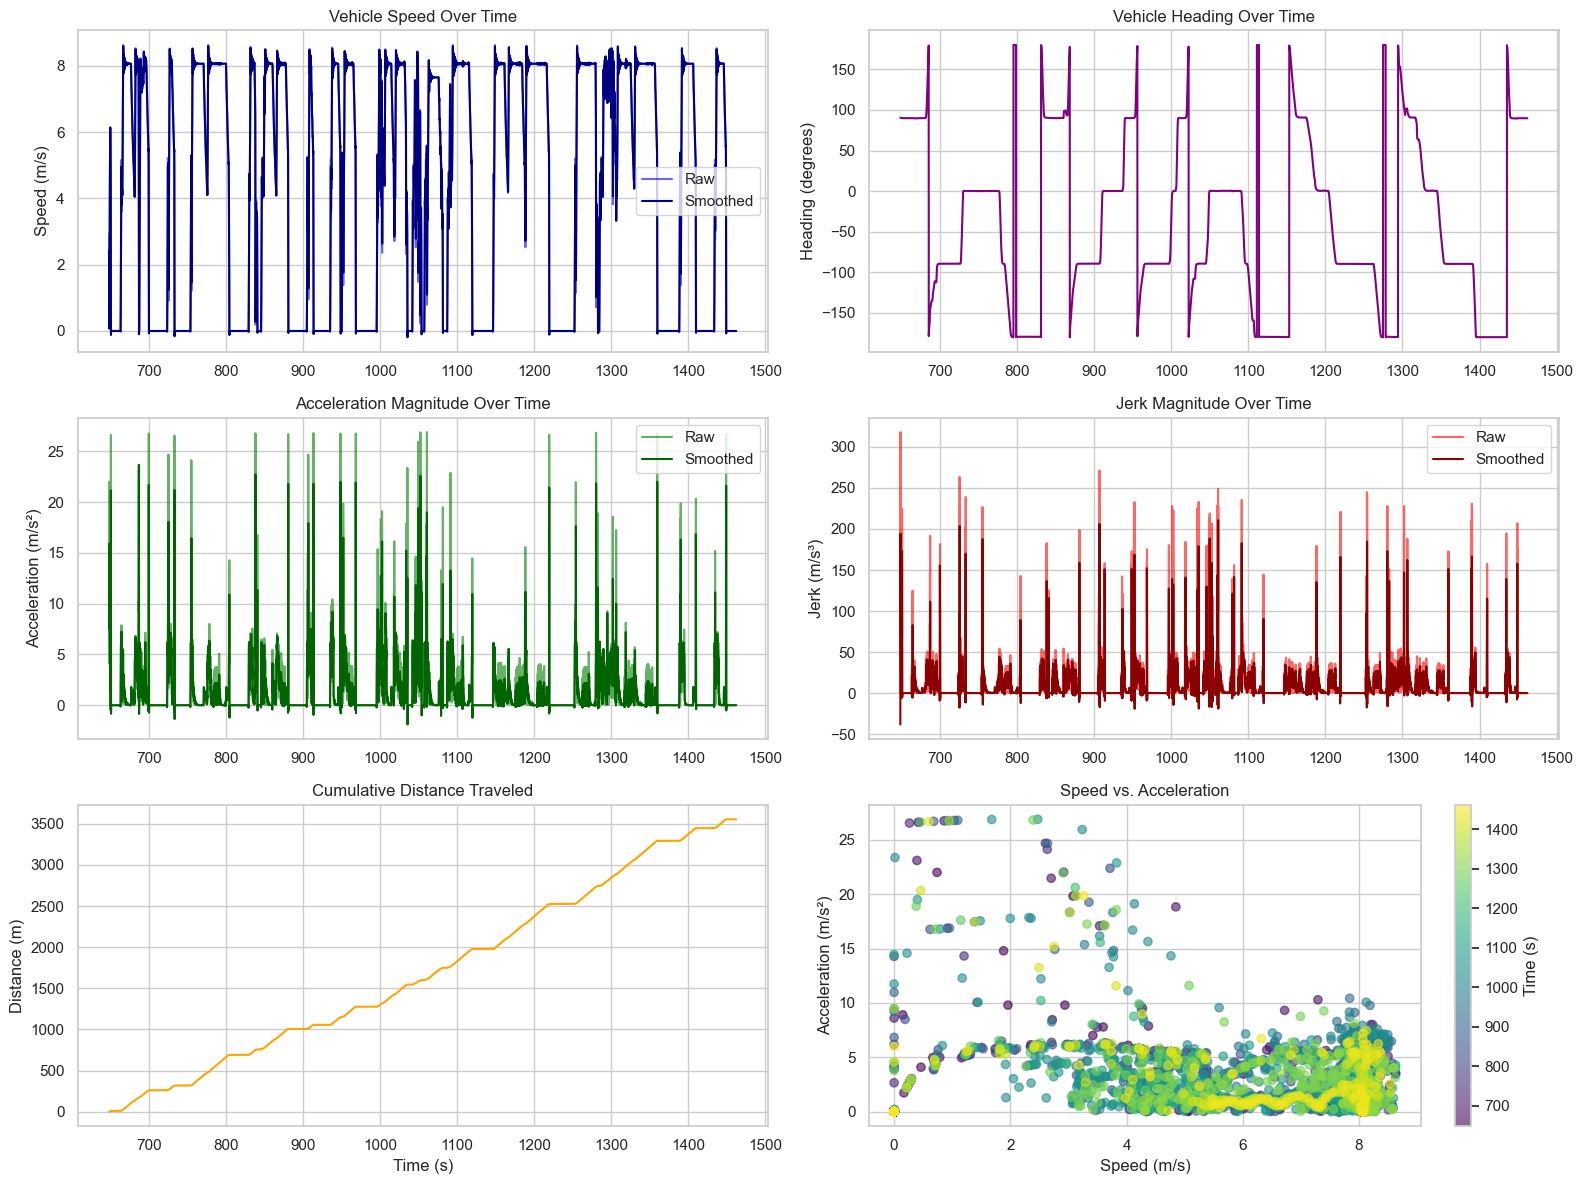

In [67]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(ego_df['timestamp'], ego_df['speed'], color='blue', alpha=0.6, label='Raw')
if 'speed_smooth' in ego_df.columns:
    plt.plot(ego_df['timestamp'], ego_df['speed_smooth'], color='navy', label='Smoothed')
plt.title('Vehicle Speed Over Time')
plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(ego_df['timestamp'], ego_df['heading'], color='purple')
plt.title('Vehicle Heading Over Time')
plt.ylabel('Heading (degrees)')
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(ego_df['timestamp'], ego_df['accel_magnitude'], color='green', alpha=0.6, label='Raw')
if 'accel_magnitude_smooth' in ego_df.columns:
    plt.plot(ego_df['timestamp'], ego_df['accel_magnitude_smooth'], color='darkgreen', label='Smoothed')
plt.title('Acceleration Magnitude Over Time')
plt.ylabel('Acceleration (m/s²)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(ego_df['timestamp'], ego_df['jerk_magnitude'], color='red', alpha=0.6, label='Raw')
if 'jerk_magnitude_smooth' in ego_df.columns:
    plt.plot(ego_df['timestamp'], ego_df['jerk_magnitude_smooth'], color='darkred', label='Smoothed')
plt.title('Jerk Magnitude Over Time')
plt.ylabel('Jerk (m/s³)')
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(ego_df['timestamp'], ego_df['cumulative_distance'], color='orange')
plt.title('Cumulative Distance Traveled')
plt.xlabel('Time (s)')
plt.ylabel('Distance (m)')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.scatter(ego_df['speed'], ego_df['accel_magnitude'], alpha=0.6, c=ego_df['timestamp'], cmap='viridis')
plt.colorbar(label='Time (s)')
plt.title('Speed vs. Acceleration')
plt.xlabel('Speed (m/s)')
plt.ylabel('Acceleration (m/s²)')
plt.grid(True)

plt.tight_layout()
plt.show()

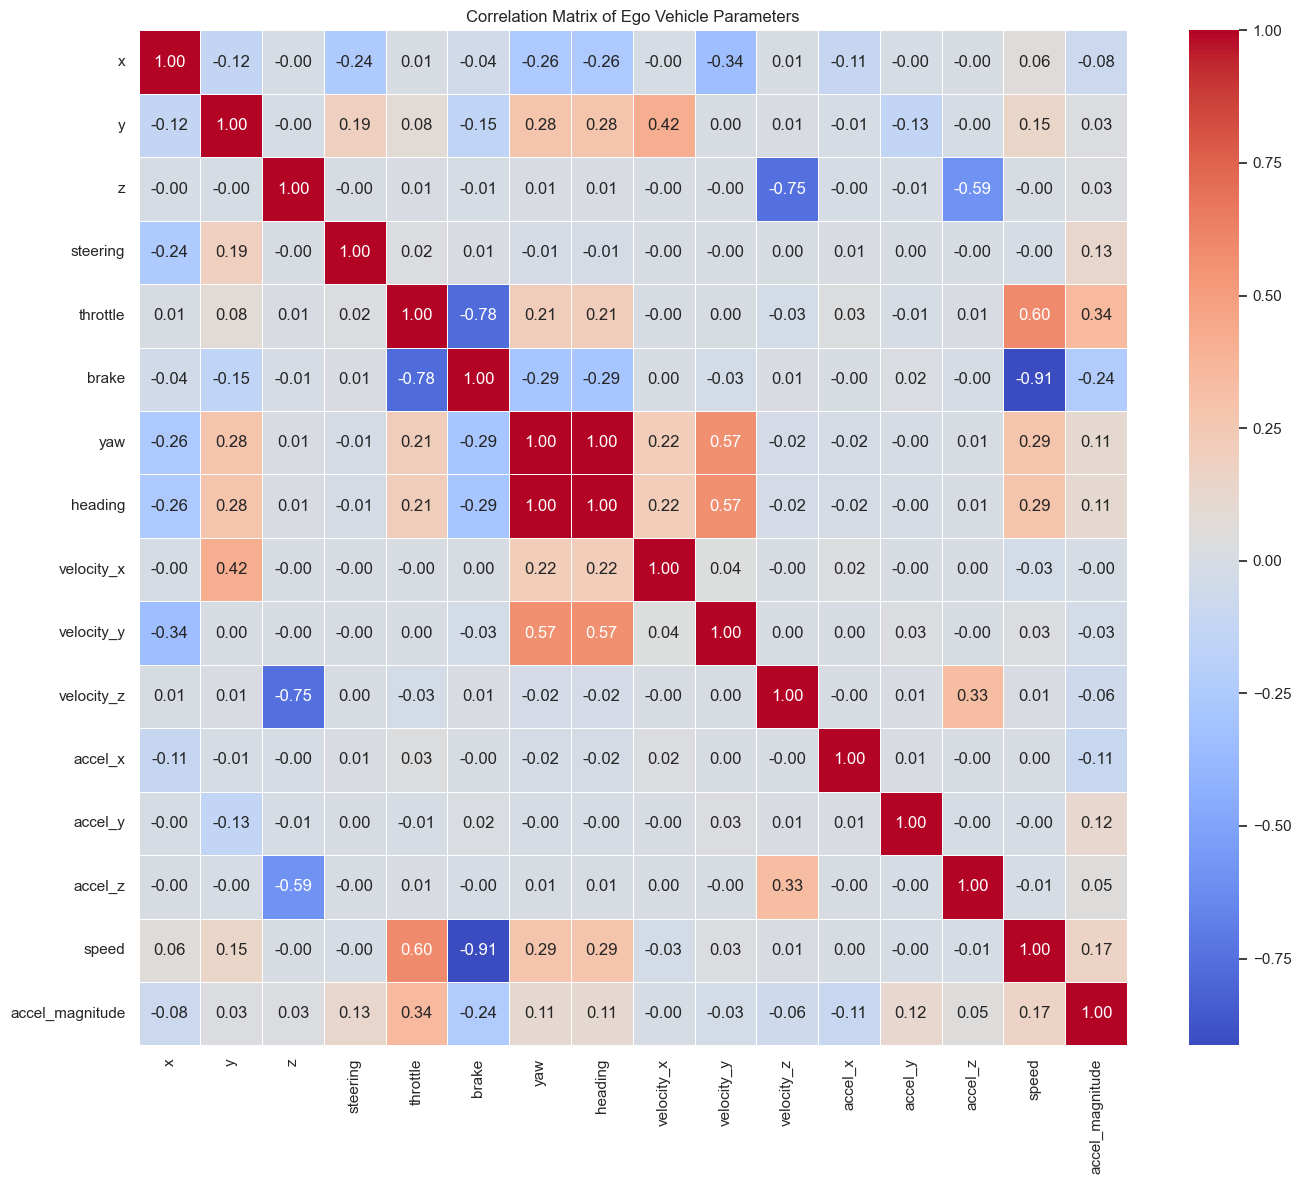

In [68]:
correlation_columns = [
    'x', 'y', 'z', 'steering', 'throttle', 'brake', 'yaw', 'heading',
    'velocity_x', 'velocity_y', 'velocity_z', 'accel_x', 'accel_y', 'accel_z',
    'speed', 'accel_magnitude'
]

# Calculate correlation matrix
corr_matrix = ego_df[correlation_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Ego Vehicle Parameters')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

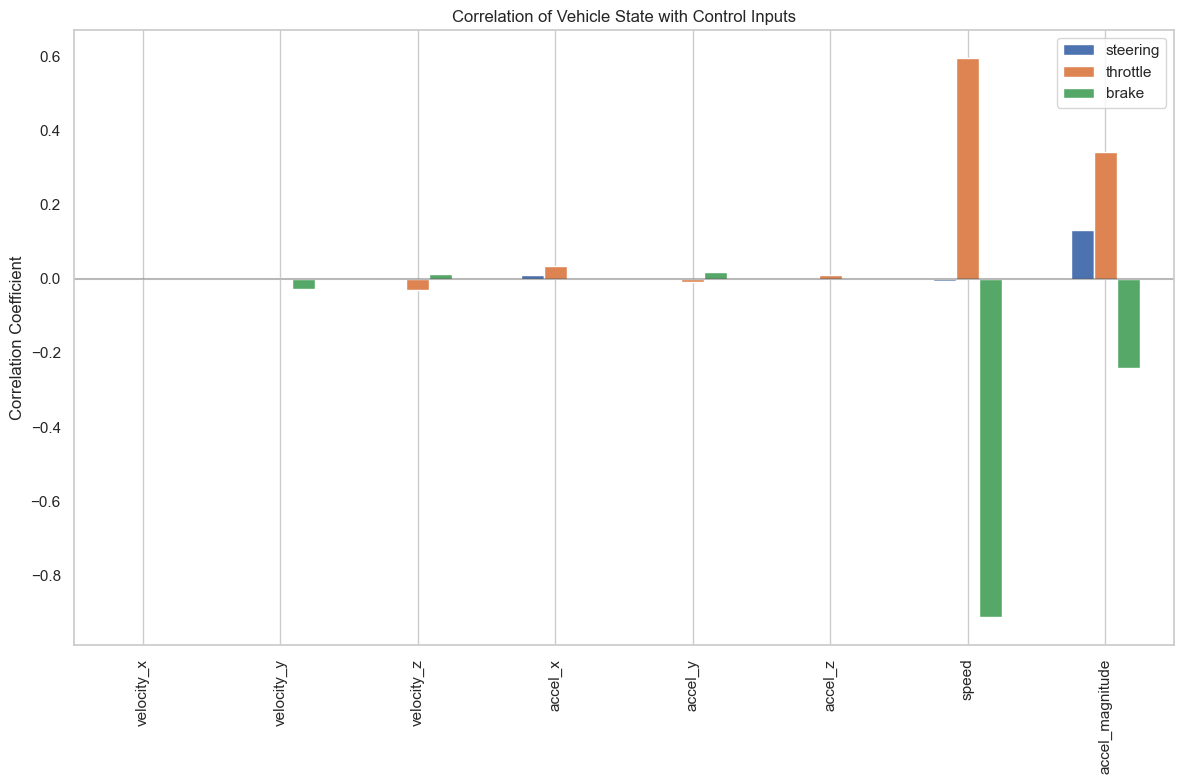

In [69]:
control_correlation = pd.DataFrame()

# Correlate current state with control inputs
for col in ['velocity_x', 'velocity_y', 'velocity_z', 'accel_x', 'accel_y', 'accel_z', 'speed', 'accel_magnitude']:
    control_correlation.loc[col, 'steering'] = ego_df[col].corr(ego_df['steering'])
    control_correlation.loc[col, 'throttle'] = ego_df[col].corr(ego_df['throttle'])
    control_correlation.loc[col, 'brake'] = ego_df[col].corr(ego_df['brake'])

# Plot correlation bars
plt.figure(figsize=(12, 8))
control_correlation.plot(kind='bar', figsize=(12, 8))
plt.title('Correlation of Vehicle State with Control Inputs')
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

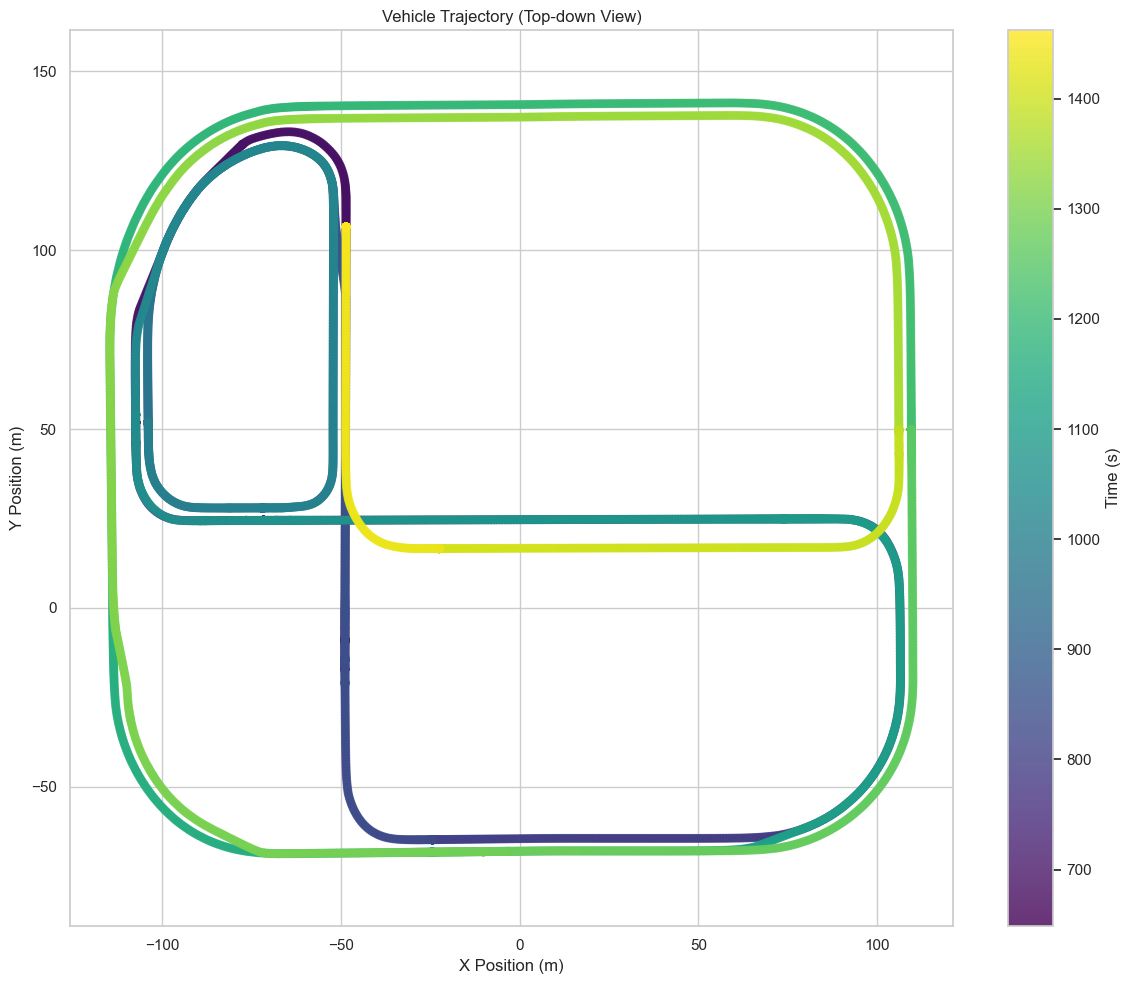

In [70]:
# 2D Vehicle trajectory plot
plt.figure(figsize=(12, 10))
plt.scatter(ego_df['x'], ego_df['y'], c=ego_df['timestamp'], cmap='viridis', s=30, alpha=0.8)
plt.colorbar(label='Time (s)')
plt.title('Vehicle Trajectory (Top-down View)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [71]:
fig = go.Figure(data=[go.Scatter3d(
    x=ego_df['x'],
    y=ego_df['y'],
    z=ego_df['z'],
    mode='markers+lines',
    marker=dict(
        size=4,
        color=ego_df['timestamp'],
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Time (s)')
    ),
    line=dict(
        color='darkblue',
        width=1
    )
)])

fig.update_layout(
    title='3D Vehicle Trajectory',
    scene=dict(
        xaxis_title='X Position (m)',
        yaxis_title='Y Position (m)',
        zaxis_title='Z Position (m)',
        aspectmode='data'
    ),
    width=900,
    height=700,
)

fig.show()

In [72]:
# Calculate vehicle kinematics at key points
# Sample at regular intervals for clarity
sample_rate = max(1, len(ego_df) // 20)  # Sample about 20 points
key_points = ego_df.iloc[::sample_rate].copy()

# Create a summary of key trajectory points
trajectory_summary = pd.DataFrame({
    'Timestamp': key_points['timestamp'],
    'X Position': key_points['x'],
    'Y Position': key_points['y'],
    'Z Position': key_points['z'],
    'Speed (m/s)': key_points['speed'],
    'Heading (deg)': key_points['heading'],
    'Acceleration (m/s²)': key_points['accel_magnitude'],
    'Steering': key_points['steering'],
    'Throttle': key_points['throttle'],
    'Brake': key_points['brake']
})

# Display the table
print("Vehicle Trajectory Summary at Key Points:")
trajectory_summary

Vehicle Trajectory Summary at Key Points:


Timestamp  X Position  Y Position  Z Position   Speed (m/s)  Heading (deg)  Acceleration (m/s²)  Steering  Throttle  Brake
0      648.568412  -48.839951  -17.213200    0.394200  1.960000e+00      90.432326         9.800002e+00 -0.004439  0.850000    0.0
406    689.168412  -82.669884  124.595932    0.001511  8.233171e+00    -135.534981         3.147025e+00  0.007044  0.020910    0.0
812    729.768413  -93.965645   24.476732    0.001863  8.040580e+00      -4.326082         1.506170e+00  0.101685  0.548506    0.0
1218   770.368413   49.166512   24.820295    0.001843  8.065261e+00       0.157013         1.682031e-02  0.000176  0.386174    0.0
1624   810.968414  -24.359266  -64.748131    0.001679  9.155274e-07    -179.334430         3.623962e-06 -0.001459  0.000000    1.0
2030   851.568415  -48.765907   16.003187    0.001860  7.930687e+00      89.815546         1.647658e+00  0.000000  0.820100    0.0
2436   892.168415 -103.818054   51.619698    0.001782  0.000000e+00     -89.370819         0.000000e+00  0.000000  0.000000    1.0
2842   932.768416  -71.909004   27.983192    0.001880  0.000000e+00       0.169565         0.000000e+00  0.000000  0.000000    1.0
3248   973.368416 -103.822227   51.927685    0.001876  0.000000e+00     -89.372827         0.000000e+00  0.000000  0.000000    1.0
3654  1013.968417  -52.074886   82.903961    0.001843  8.065815e+00      89.842287         1.861579e-02  0.000000  0.382716    0.0
4060  1054.568418  -76.374069   24.465483    0.001689  3.846944e-06       0.286276         9.604997e-05 -0.001717  0.000000    1.0
4466  1095.168418  105.886124    9.444113    0.001732  8.375233e+00     -80.741511         4.507127e+00 -0.155814  0.191414    0.0
4872  1135.768419  -24.388063  -68.249046    0.001679  1.239804e-07    -179.508983         7.629942e-07  0.002369  0.000000    1.0
5278  1176.368419 -114.305954   80.668358    0.001844  8.067765e+00      86.951744         1.243465e-01 -0.006737  0.373773    0.0
5684  1216.968420  109.427711   64.638893    0.001899  7.249119e+00     -89.608277         4.606475e-01  0.000176  0.284925    0.0
6090  1257.568421  109.727242   20.330862    0.001857  7.979527e+00     -89.612123         8.627088e-01  0.000000  0.635979    0.0
6496  1298.168421  -94.226570  -56.392254    0.001903  7.129415e+00     141.175463         2.048452e+00 -0.050678  0.850000    0.0
6902  1338.768422   12.257547  137.378510    0.001842  8.066798e+00       0.717993         5.019425e-03 -0.001537  0.383915    0.0
7308  1379.368422  106.027290   49.766972    0.001739  0.000000e+00     -89.610470         0.000000e+00  0.000000  0.000000    1.0
7714  1419.968423  -22.415346   16.621729    0.001832  0.000000e+00    -179.842296         0.000000e+00  0.000000  0.000000    1.0
8120  1460.568424  -48.495930  106.499092    0.001679  7.534317e-07      89.765385         3.058700e-06  0.003202  0.000000    1.0

In [73]:
# Calculate driving behavior statistics
ego_stats = pd.DataFrame({
    'Average Speed (m/s)': [ego_df['speed'].mean()],
    'Max Speed (m/s)': [ego_df['speed'].max()],
    'Average Acceleration (m/s²)': [ego_df['accel_magnitude'].mean()],
    'Max Acceleration (m/s²)': [ego_df['accel_magnitude'].max()],
    'Average Jerk (m/s³)': [ego_df['jerk_magnitude'].mean()],
    'Max Jerk (m/s³)': [ego_df['jerk_magnitude'].max()],
    'Total Distance (m)': [ego_df['cumulative_distance'].max()],
    'Duration (s)': [ego_df['timestamp'].max() - ego_df['timestamp'].min()],
    'Average Steering': [abs(ego_df['steering']).mean()],
    'Throttle Usage (%)': [(ego_df['throttle'] > 0.1).mean() * 100],
    'Brake Usage (%)': [(ego_df['brake'] > 0.1).mean() * 100]
})

# Display driving statistics
print("Vehicle Driving Behavior Statistics:")
ego_stats.T

Vehicle Driving Behavior Statistics:


0
Average Speed (m/s)             4.371728
Max Speed (m/s)                 8.631734
Average Acceleration (m/s²)     1.288902
Max Acceleration (m/s²)        26.890598
Average Jerk (m/s³)             9.503523
Max Jerk (m/s³)               318.072343
Total Distance (m)           3555.555598
Duration (s)                  813.500012
Average Steering                0.022126
Throttle Usage (%)             55.408063
Brake Usage (%)                42.109145

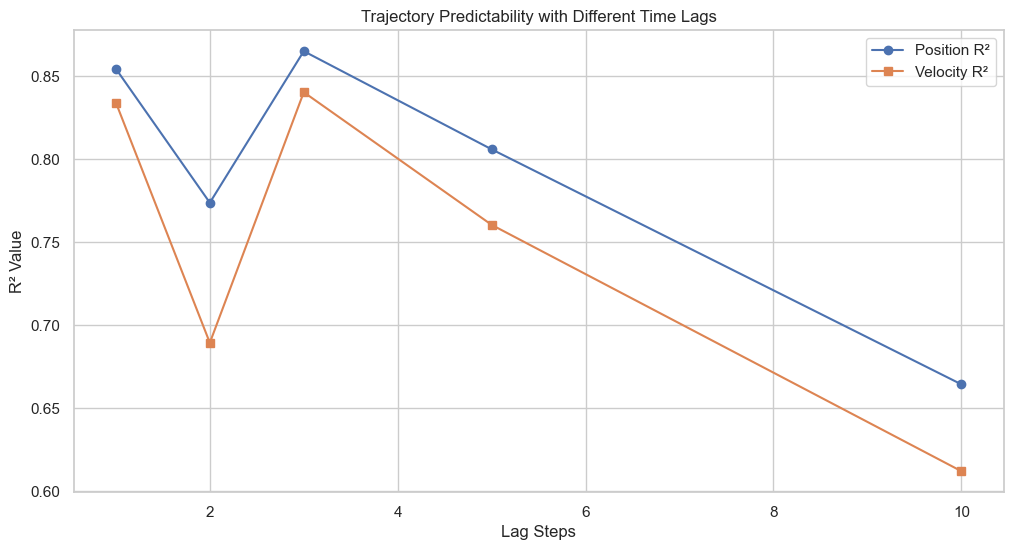

Trajectory Predictability Analysis:


Lag  Position_R2  Velocity_R2
0   1.0     0.854612     0.834214
1   2.0     0.773805     0.689281
2   3.0     0.865239     0.840476
3   5.0     0.806016     0.760443
4  10.0     0.664232     0.611830

In [74]:
# Analyze how predictable the trajectory is by lagged features
lag_steps = [1, 2, 3, 5, 10]
position_cols = ['x', 'y', 'z']
prediction_results = pd.DataFrame(columns=['Lag', 'Position_R2', 'Velocity_R2'])

for lag in lag_steps:
    # Shift data to create lagged features
    for col in position_cols + ['velocity_x', 'velocity_y', 'velocity_z']:
        ego_df[f'{col}_lag{lag}'] = ego_df[col].shift(lag)
    
    # Prepare data (remove rows with NaN from shifting)
    lagged_df = ego_df.dropna()
    
    # Measure R² for position prediction
    position_r2 = []
    velocity_r2 = []
    
    for i, pos_col in enumerate(position_cols):
        # Position predictability
        X = lagged_df[[f'{pos_col}_lag{lag}']]
        y = lagged_df[pos_col]
        
        # Calculate R² for simple linear prediction
        slope, intercept, r_value, p_value, std_err = stats.linregress(X[f'{pos_col}_lag{lag}'], y)
        position_r2.append(r_value**2)
        
        # Velocity predictability
        vel_col = f'velocity_{pos_col[-1]}'  # velocity_x, velocity_y, velocity_z
        X_vel = lagged_df[[f'{vel_col}_lag{lag}']]
        y_vel = lagged_df[vel_col]
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(X_vel[f'{vel_col}_lag{lag}'], y_vel)
        velocity_r2.append(r_value**2)
    
    # Store average R² results
    prediction_results = prediction_results.append({
        'Lag': lag,
        'Position_R2': np.mean(position_r2),
        'Velocity_R2': np.mean(velocity_r2)
    }, ignore_index=True)
    
    # Clean up temporary columns
    for col in position_cols + ['velocity_x', 'velocity_y', 'velocity_z']:
        ego_df.drop(f'{col}_lag{lag}', axis=1, inplace=True)

# Plot predictability results
plt.figure(figsize=(12, 6))
plt.plot(prediction_results['Lag'], prediction_results['Position_R2'], 'o-', label='Position R²')
plt.plot(prediction_results['Lag'], prediction_results['Velocity_R2'], 's-', label='Velocity R²')
plt.title('Trajectory Predictability with Different Time Lags')
plt.xlabel('Lag Steps')
plt.ylabel('R² Value')
plt.legend()
plt.grid(True)
plt.show()

print("Trajectory Predictability Analysis:")
prediction_results

In [76]:
fig = go.Figure()

# Add vehicle trajectory
fig.add_trace(go.Scatter(
    x=ego_df['x'],
    y=ego_df['y'],
    mode='lines+markers',
    name='Vehicle Path',
    line=dict(width=2, color='darkblue'),
    marker=dict(
        size=8,
        color=ego_df['speed'],
        colorscale='Viridis',
        colorbar=dict(title='Speed (m/s)'),
        showscale=True
    ),
    hovertemplate=
    '<b>Time</b>: %{customdata[0]:.2f}s<br>' +
    '<b>Position</b>: (%{x:.2f}, %{y:.2f})<br>' +
    '<b>Speed</b>: %{customdata[1]:.2f} m/s<br>' +
    '<b>Heading</b>: %{customdata[2]:.2f}°<br>' +
    '<b>Steering</b>: %{customdata[3]:.2f}<br>' +
    '<b>Throttle</b>: %{customdata[4]:.2f}<br>' +
    '<b>Brake</b>: %{customdata[5]:.2f}',
    customdata=np.vstack((
        ego_df['timestamp'],
        ego_df['speed'],
        ego_df['heading'],
        ego_df['steering'],
        ego_df['throttle'],
        ego_df['brake']
    )).T
))

# Update layout
fig.update_layout(
    title='Interactive Vehicle Trajectory',
    xaxis_title='X Position (m)',
    yaxis_title='Y Position (m)',
    hovermode='closest',
    width=900,
    height=700,
)

fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
)

fig.show()


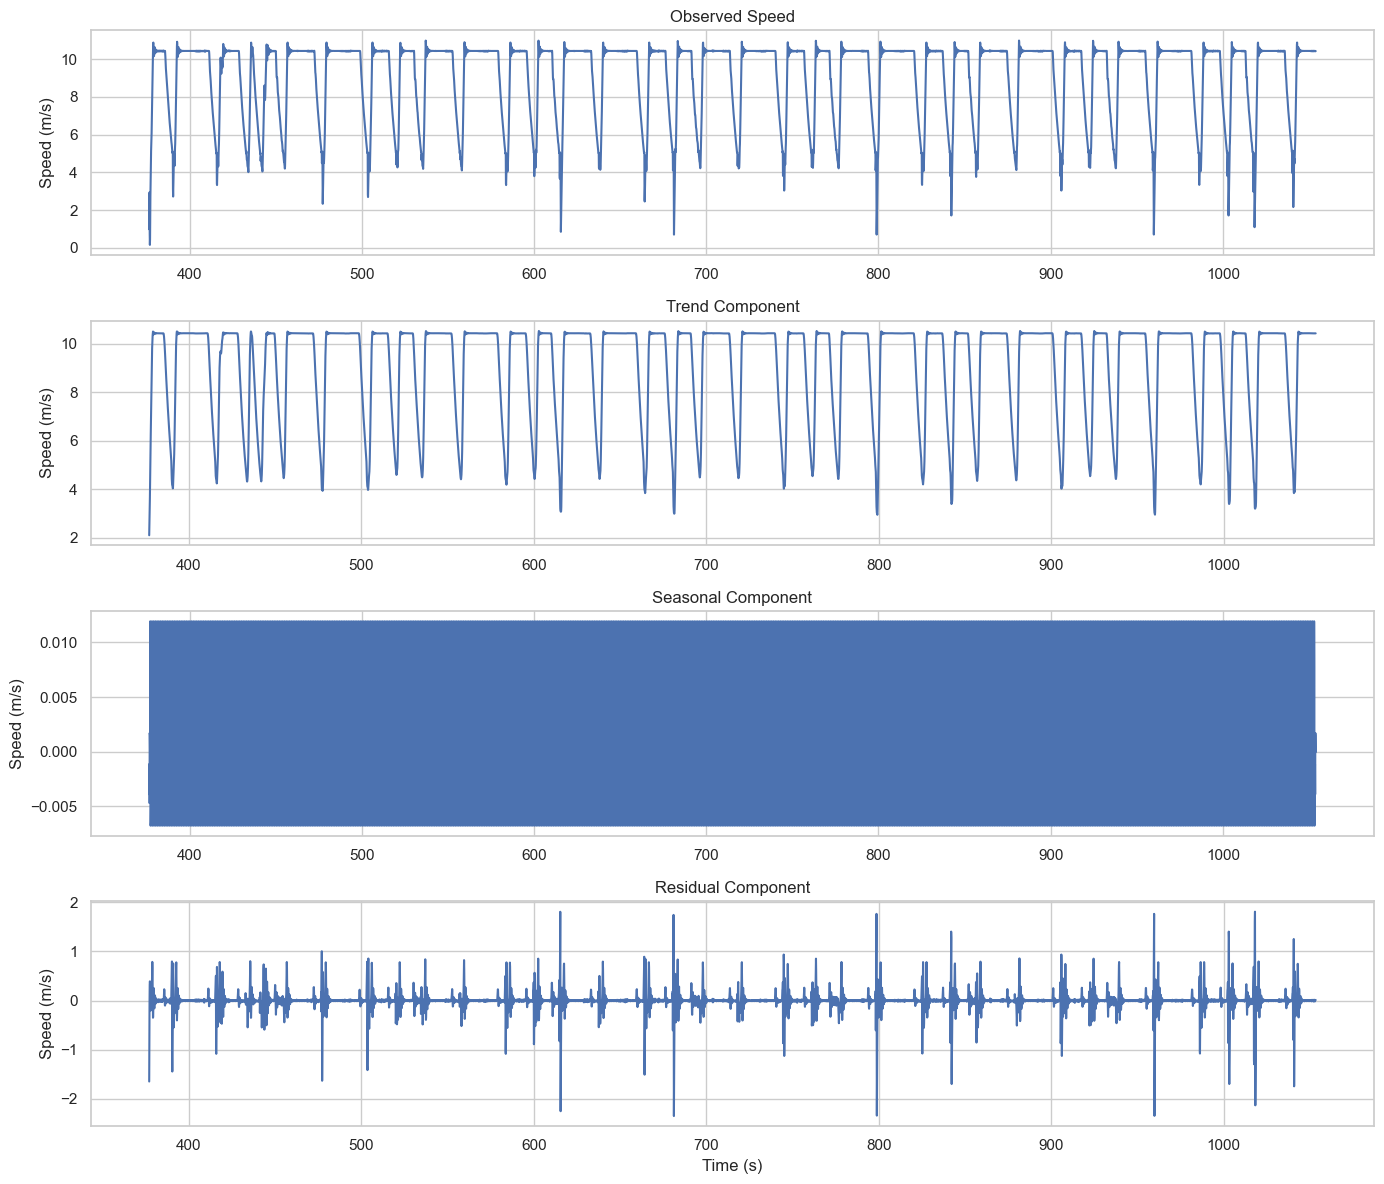

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure we have enough data points for decomposition
if len(ego_df) > 20:
    # Resample data to ensure uniform time steps if needed
    time_series = ego_df.set_index('timestamp')['speed'].sort_index()
    
    # Fill any missing values
    time_series = time_series.fillna(method='ffill').fillna(method='bfill')
    
    # Check if we have a reasonable number of periods
    try:
        # Try to decompose the time series (adjust period as needed)
        # For vehicle data, a good period might be related to the average time to complete a driving maneuver
        period = min(len(time_series) // 4, 10)  # Use at most 1/4 of the data length or 10 points
        
        if period >= 2:  # Need at least 2 periods for decomposition
            decomposition = seasonal_decompose(time_series, model='additive', period=period)
            
            # Plot decomposition
            plt.figure(figsize=(14, 12))
            
            plt.subplot(4, 1, 1)
            plt.plot(decomposition.observed)
            plt.title('Observed Speed')
            plt.ylabel('Speed (m/s)')
            plt.grid(True)
            
            plt.subplot(4, 1, 2)
            plt.plot(decomposition.trend)
            plt.title('Trend Component')
            plt.ylabel('Speed (m/s)')
            plt.grid(True)
            
            plt.subplot(4, 1, 3)
            plt.plot(decomposition.seasonal)
            plt.title('Seasonal Component')
            plt.ylabel('Speed (m/s)')
            plt.grid(True)
            
            plt.subplot(4, 1, 4)
            plt.plot(decomposition.resid)
            plt.title('Residual Component')
            plt.xlabel('Time (s)')
            plt.ylabel('Speed (m/s)')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Could not perform time series decomposition: {e}")
else:
    print("Not enough data points for time series decomposition")


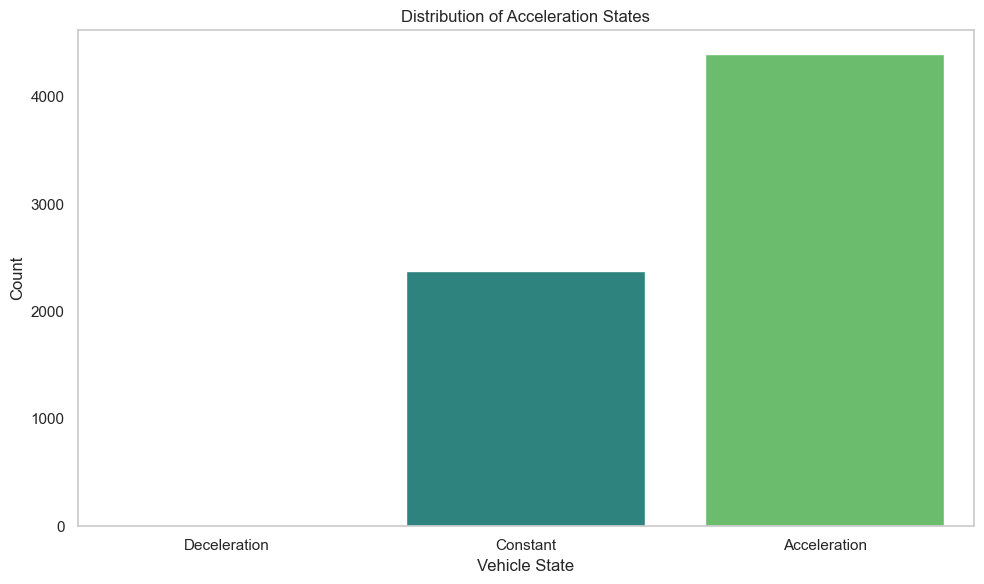

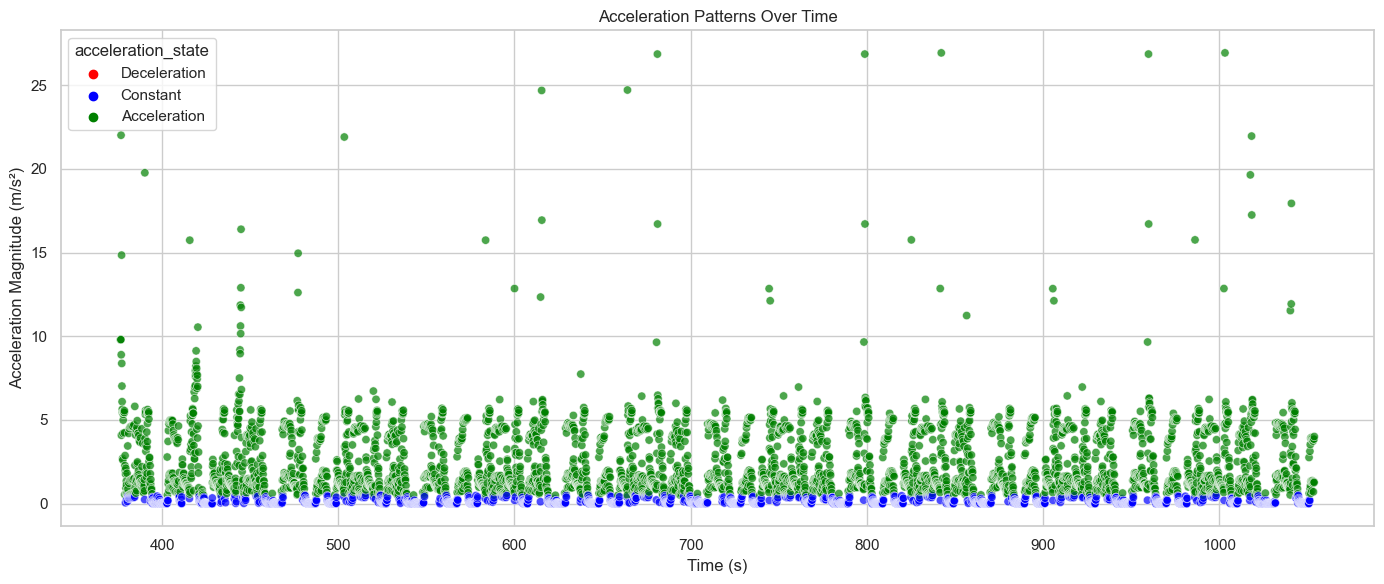

In [ ]:
ego_df['acceleration_state'] = pd.cut(
    ego_df['accel_magnitude'] * ego_df['speed'].apply(lambda x: 1 if x > 0 else 0),
    bins=[-float('inf'), -0.5, 0.5, float('inf')],
    labels=['Deceleration', 'Constant', 'Acceleration']
)

# Count acceleration states
acceleration_counts = ego_df['acceleration_state'].value_counts()

# Plot acceleration state distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='acceleration_state', data=ego_df, palette='viridis')
plt.title('Distribution of Acceleration States')
plt.xlabel('Vehicle State')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot acceleration patterns over time
plt.figure(figsize=(14, 6))
sns.scatterplot(
    x='timestamp',
    y='accel_magnitude',
    hue='acceleration_state',
    palette={'Acceleration': 'green', 'Constant': 'blue', 'Deceleration': 'red'},
    data=ego_df,
    alpha=0.7
)
plt.title('Acceleration Patterns Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration Magnitude (m/s²)')
plt.grid(True)
plt.tight_layout()
plt.show()

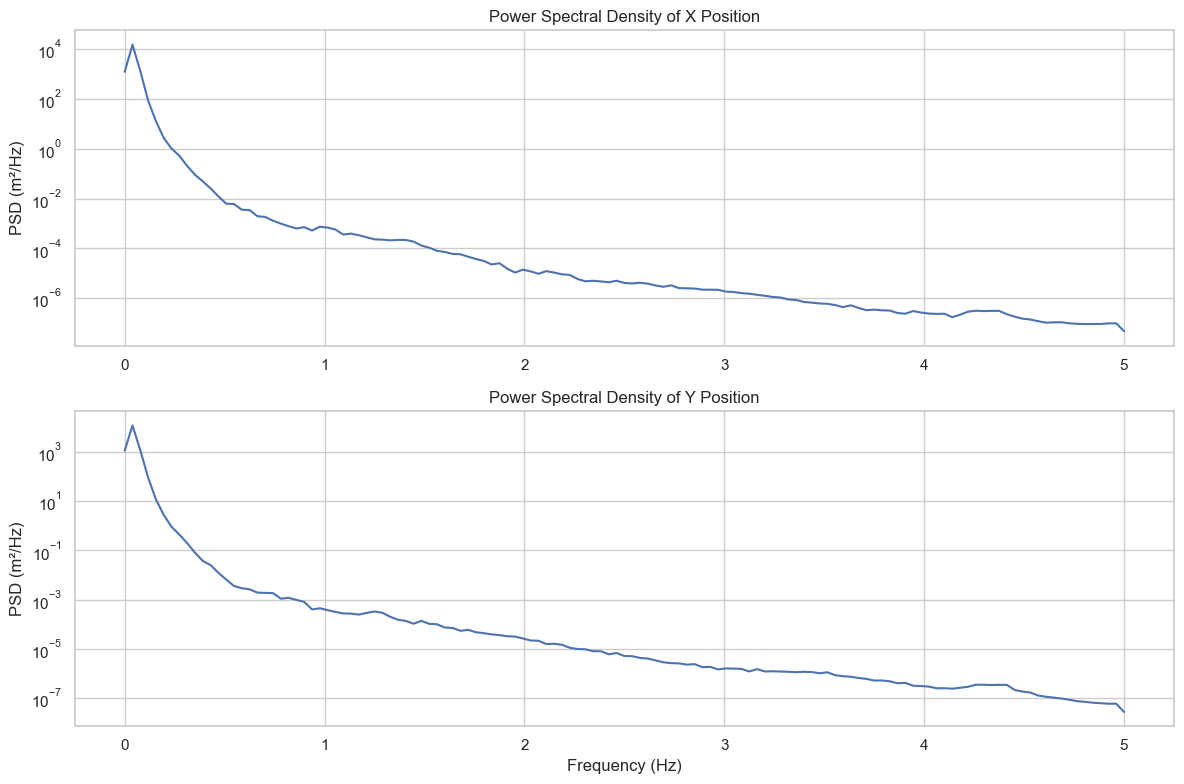

Dominant frequency in X direction: 0.0391 Hz
Dominant frequency in Y direction: 0.0391 Hz
This suggests patterns that repeat approximately every 25.60s (X) and 25.60s (Y)


In [ ]:
# Perform spectral analysis of vehicle movement
from scipy import signal

# Ensure we have enough data points
if len(ego_df) > 20:
    # Prepare data for spectral analysis
    # Detrend the position data to focus on oscillatory patterns
    x_detrended = signal.detrend(ego_df['x'])
    y_detrended = signal.detrend(ego_df['y'])
    
    # Compute power spectral density
    fs = 1.0 / np.mean(np.diff(ego_df['timestamp']))  # approximate sampling frequency
    
    f_x, pxx_x = signal.welch(x_detrended, fs, nperseg=min(256, len(x_detrended)//2))
    f_y, pxx_y = signal.welch(y_detrended, fs, nperseg=min(256, len(y_detrended)//2))
    
    # Plot power spectral density
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.semilogy(f_x, pxx_x)
    plt.title('Power Spectral Density of X Position')
    plt.ylabel('PSD (m²/Hz)')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.semilogy(f_y, pxx_y)
    plt.title('Power Spectral Density of Y Position')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (m²/Hz)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Determine dominant frequencies
    dominant_freq_x = f_x[np.argmax(pxx_x)]
    dominant_freq_y = f_y[np.argmax(pxx_y)]
    
    print(f"Dominant frequency in X direction: {dominant_freq_x:.4f} Hz")
    print(f"Dominant frequency in Y direction: {dominant_freq_y:.4f} Hz")
    print(f"This suggests patterns that repeat approximately every {1/dominant_freq_x:.2f}s (X) and {1/dominant_freq_y:.2f}s (Y)")
else:
    print("Not enough data points for spectral analysis")

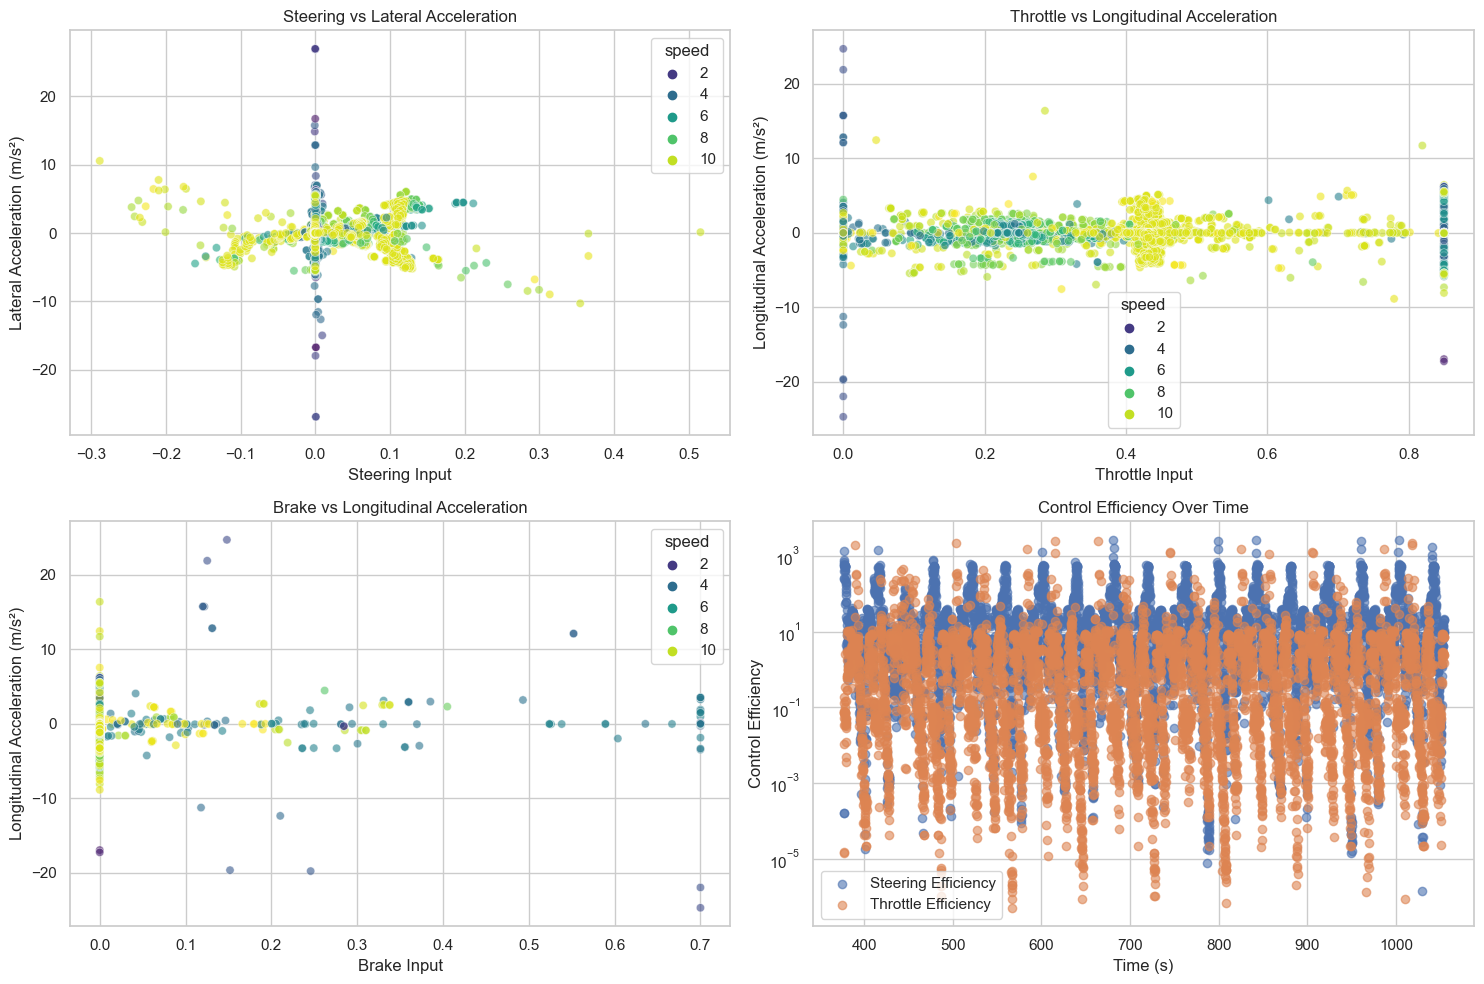

In [ ]:
plt.figure(figsize=(15, 10))

# 1. Steering vs Lateral Acceleration
plt.subplot(2, 2, 1)
sns.scatterplot(x='steering', y='accel_y', data=ego_df, alpha=0.6, hue='speed', palette='viridis')
plt.title('Steering vs Lateral Acceleration')
plt.xlabel('Steering Input')
plt.ylabel('Lateral Acceleration (m/s²)')
plt.grid(True)

# 2. Throttle vs Longitudinal Acceleration
plt.subplot(2, 2, 2)
sns.scatterplot(x='throttle', y='accel_x', data=ego_df, alpha=0.6, hue='speed', palette='viridis')
plt.title('Throttle vs Longitudinal Acceleration')
plt.xlabel('Throttle Input')
plt.ylabel('Longitudinal Acceleration (m/s²)')
plt.grid(True)

# 3. Brake vs Longitudinal Deceleration
plt.subplot(2, 2, 3)
sns.scatterplot(x='brake', y='accel_x', data=ego_df, alpha=0.6, hue='speed', palette='viridis')
plt.title('Brake vs Longitudinal Acceleration')
plt.xlabel('Brake Input')
plt.ylabel('Longitudinal Acceleration (m/s²)')
plt.grid(True)

# 4. Control Stability Index
# Calculate a simple control stability index: how much control input creates how much response
ego_df['steering_efficiency'] = abs(ego_df['accel_y']) / (abs(ego_df['steering']) + 0.01)  # Avoid div by zero
ego_df['throttle_efficiency'] = abs(ego_df['accel_x']) / (abs(ego_df['throttle']) + 0.01)  # Avoid div by zero

plt.subplot(2, 2, 4)
plt.scatter(ego_df['timestamp'], ego_df['steering_efficiency'], alpha=0.6, label='Steering Efficiency')
plt.scatter(ego_df['timestamp'], ego_df['throttle_efficiency'], alpha=0.6, label='Throttle Efficiency')
plt.title('Control Efficiency Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Control Efficiency')
plt.yscale('log')  # Log scale to handle wide range of values
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Created 63 features for trajectory prediction
Feature DataFrame shape: (6762, 63)
Target DataFrame shape: (6762, 15)

Top 5 most predictive features:
        future_x_1  future_y_1  future_z_1  future_x_2  future_y_2  future_z_2  future_x_3  future_y_3  future_z_3  future_x_4  future_y_4  future_z_4  future_x_5  future_y_5  future_z_5  mean_abs_corr
y_lag3   -0.018024    0.999425   -0.035344   -0.024467    0.999102   -0.034968   -0.030911    0.998708   -0.034520   -0.037355    0.998243   -0.034083   -0.043798    0.997706   -0.033649       0.354687
x_lag3    0.999442    0.034338   -0.014275    0.999128    0.040985   -0.016494    0.998745    0.047631   -0.017773    0.998292    0.054274   -0.018427    0.997770    0.060915   -0.018897       0.354492
y_lag2   -0.011367    0.999677   -0.035714   -0.017811    0.999425   -0.035344   -0.024255    0.999102   -0.034901   -0.030699    0.998708   -0.034471   -0.037144    0.998242   -0.034046       0.352727
x_lag2    0.999686    0.027912   -0.014041

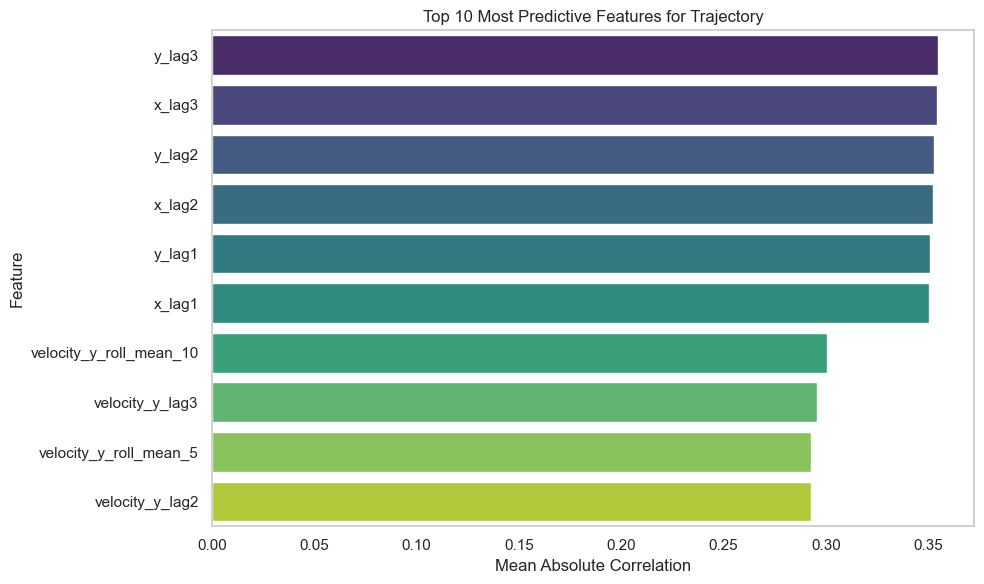

In [ ]:
def create_prediction_features(df, lag_steps=[1, 2, 3], prediction_horizon=5):
    """
    Create features for trajectory prediction:
    - Lagged position, velocity features
    - Rolling statistics
    - Derived features (e.g., acceleration changes)
    
    Parameters:
    - df: DataFrame with trajectory data
    - lag_steps: List of lag steps to create features
    - prediction_horizon: How many steps ahead to predict
    
    Returns:
    - X: Feature DataFrame
    - y: Target DataFrame (future positions)
    """
    # Create a copy to avoid modifying the original
    data = df.copy()
    
    # Features we want to use
    base_features = ['x', 'y', 'z', 'velocity_x', 'velocity_y', 'velocity_z', 
                    'accel_x', 'accel_y', 'accel_z', 'steering', 'throttle', 'brake']
    
    # Create lagged features
    for lag in lag_steps:
        for feat in base_features:
            data[f'{feat}_lag{lag}'] = data[feat].shift(lag)
    
    # Create rolling statistics (mean, std)
    window_sizes = [3, 5, 10]
    
    for window in window_sizes:
        if len(data) >= window:
            for feat in ['velocity_x', 'velocity_y', 'accel_x', 'accel_y']:
                data[f'{feat}_roll_mean_{window}'] = data[feat].rolling(window=window).mean()
                data[f'{feat}_roll_std_{window}'] = data[feat].rolling(window=window).std()
    
    # Create derived features
    # Change in acceleration (jerk)
    data['accel_x_change'] = data['accel_x'].diff()
    data['accel_y_change'] = data['accel_y'].diff()
    
    # Change in steering
    data['steering_change'] = data['steering'].diff()
    
    # Create target variables: future positions
    for horizon in range(1, prediction_horizon + 1):
        data[f'future_x_{horizon}'] = data['x'].shift(-horizon)
        data[f'future_y_{horizon}'] = data['y'].shift(-horizon)
        data[f'future_z_{horizon}'] = data['z'].shift(-horizon)
    
    # Drop NaN values (from shifting operations)
    data = data.dropna()
    
    if len(data) == 0:
        print("Warning: No data left after creating features and removing NaNs")
        return None, None
    
    # Create feature matrix X and target matrix y
    feature_cols = [col for col in data.columns if ('lag' in col or 'roll' in col or 'change' in col)]
    target_cols = [col for col in data.columns if 'future' in col]
    
    X = data[feature_cols]
    y = data[target_cols]
    
    return X, y

# Create prediction features if we have enough data
if len(ego_df) > 20:  # Need sufficient data points
    X_features, y_targets = create_prediction_features(ego_df)
    
    if X_features is not None and y_targets is not None:
        print(f"Created {X_features.shape[1]} features for trajectory prediction")
        print(f"Feature DataFrame shape: {X_features.shape}")
        print(f"Target DataFrame shape: {y_targets.shape}")
        
        # Show top 5 most important features (based on correlation with targets)
        if X_features.shape[0] > 5:  # Need enough samples
            correlations = pd.DataFrame()
            
            for y_col in y_targets.columns:
                # Calculate correlation of each feature with this target
                for x_col in X_features.columns:
                    correlations.loc[x_col, y_col] = X_features[x_col].corr(y_targets[y_col])
            
            # Calculate mean absolute correlation across all targets
            correlations['mean_abs_corr'] = correlations.abs().mean(axis=1)
            
            # Display top features
            print("\nTop 5 most predictive features:")
            print(correlations.sort_values('mean_abs_corr', ascending=False).head(5))
            
            # Visualize feature importance
            plt.figure(figsize=(10, 6))
            top_features = correlations.sort_values('mean_abs_corr', ascending=False).head(10).index
            
            sns.barplot(
                x='mean_abs_corr',
                y=correlations.loc[top_features].index,
                data=correlations.loc[top_features].reset_index(),
                palette='viridis'
            )
            plt.title('Top 10 Most Predictive Features for Trajectory')
            plt.xlabel('Mean Absolute Correlation')
            plt.ylabel('Feature')
            plt.grid(axis='x')
            plt.tight_layout()
            plt.show()
else:
    print("Not enough data points for feature engineering")